In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm 
from sklearn import linear_model 
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn import metrics

import math
def df_r(sc, d_f):
    d_f[d_f.columns.values] = sc.inverse_transform(d_f[d_f.columns.values])
    return d_f
def accuracy_val(YY_test,predictt_result):
    text_index=    {
        'Label':'Label',
        'Y_RFR_pred':'Ground truth',
        'Y_svm_pred':'svm.SVR',
        'Y_BR_pred':'BayesianRidge',
        'Y_KNN_pred':'KNN'
    }
        
    lab = YY_test['Label'][:-1].reset_index() -YY_test['Label'][1:].reset_index() 
    lab[lab<0]=-1
    lab[lab>0]=1
    out = predictt_result[:-1].reset_index() -predictt_result[1:].reset_index() 
    out[out<0]=-1
    out[out>0]=1
    out = out.drop(['index'], axis=1)
    out_str=''
    for name in out:
        ans = out[name]==lab['Label']

        out_str+=text_index[name]+' Direction Accuracy:'+str(sum(ans)/len(out[name]))+'\n'
    return out_str

def show_plot_dataframe(title_name, predictt_result, YY_test,f_n,label_nal,training_set):

    YY_test = df_r(label_nal, YY_test.copy())
    predictt_result = df_r(label_nal, predictt_result.copy())

    x = np.linspace(1,len(YY_test),len(YY_test))
    ax=plt.figure(figsize=(20,10))

    plt.xticks([])
    l1 = plt.plot(x, YY_test['Label'].values.tolist(), linewidth=5, color='blue',   label='true', linestyle="--")
    l2 = plt.plot(x, predictt_result['Y_RFR_pred'],    linewidth=5, color='red',   label='RandomForestRegressor')
    l4 = plt.plot(x, predictt_result['Y_svm_pred'],    linewidth=5, color='lime',   label='svm.SVR')
    l6 = plt.plot(x, predictt_result['Y_BR_pred'],     linewidth=5, color='black',   label='BayesianRidge')
    l11 = plt.plot(x, predictt_result['Y_KNN_pred'],   linewidth=5, color='purple',   label='KNN')
    
    m = math.floor(len(YY_test)/30)
    x_range_n = np.arange(1,len(YY_test),1 if m<=0 else m)

    print(f_n)
    plt.savefig(f_n+'.png', transparent=True)

from sklearn.metrics import accuracy_score
def Shaking(T):
    T  = T[0:-2]-T[1:-1]
    T[T<0]=-1
    T[T>0]=1
    return T

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
def evaluation(y_true, x_true, y_pred,title_name):
    y_true = np.reshape(np.array(y_true),(y_true.shape[0]))
    x_true = np.reshape(np.array(x_true),(x_true.shape[0]))
    y_pred = np.array(y_pred)
    MSE_   = str(metrics.mean_squared_error(y_true, y_pred))
    RMSE_  = str(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    MAE_   = str(metrics.mean_absolute_error(y_true, y_pred))
    MAPE_  = str(mape(y_true, y_pred))
    SMAPE_ = str(smape(y_true, y_pred))
    return '\t'+title_name+':\n \t\tRMSE:'+RMSE_+'\n\t\tMAPE:'+MAPE_+'\n'
    
def print_evaluation(X_test, Y_test, predict_result,f_n):
    
    s1=evaluation(Y_test, X_test['Close'], predict_result['Y_RFR_pred'],  'RandomForestRegressor')
    s2=evaluation(Y_test, X_test['Close'], predict_result['Y_svm_pred'],  'svm.SVR')
    s3=evaluation(Y_test, X_test['Close'], predict_result['Y_KNN_pred'],  'KNN')
    s4=evaluation(Y_test, X_test['Close'], predict_result['Y_BR_pred'],   'BayesianRidge')

    print(s1+s2+s3+s4)

def set_train_model():
    RFR = RandomForestRegressor( verbose=0, random_state=1234,max_depth=51) 
    svm_ = svm.LinearSVR(random_state=1234)
    KNN = KNeighborsRegressor(n_neighbors=2)
    BR = linear_model.BayesianRidge()
    TSR=linear_model.TheilSenRegressor()
    MTENCV = linear_model.MultiTaskElasticNetCV()
    MTENSSOCV = linear_model.MultiTaskLassoCV()
    return [RFR, svm_, KNN, BR] 

def run_gridsearch(set_m, X_train,y_train,X_test,y_test):
    y_test = np.array(y_test).ravel()
    y_train = np.array(y_train).ravel()
    RF_param = {"n_estimators":[10,100,1000]}
    GSCV = GridSearchCV(set_m[0],param_grid=RF_param,cv=5)
    GSCV.fit(X_train,y_train)
    print("accuracy score",GSCV.score(X_test,y_test))
    print("The best model param :",GSCV.best_params_)
def set_train_fit(XX_, YY_, set_m):
    YY_ = np.array(YY_).ravel()
    set_m[0].fit(XX_, YY_)
    set_m[1].fit(XX_, YY_)
    set_m[2].fit(XX_, YY_)
    set_m[3].fit(XX_, YY_)

    return set_m.copy()

def train_predict(XX_, YY_, set_m):
    Y_RFR_pred = set_m[0].predict(XX_)
    Y_svm_pred = set_m[1].predict(XX_)
    Y_KNN_pred = set_m[2].predict(XX_)
    Y_BR_pred  = set_m[3].predict(XX_)

    predict_result    = pd.DataFrame([  
                            Y_RFR_pred,
                            Y_svm_pred,
                            Y_KNN_pred,
                            Y_BR_pred
                                  ]).T
    predict_result.columns=[
                            'Y_RFR_pred',
                            'Y_svm_pred',
                            'Y_KNN_pred',
                            'Y_BR_pred'
                            ]
    return predict_result

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
folder_name ='data+/'
file_name = '0050.TW.csv' 
day_n = 20 
importance_n=0.06

training_set = pd.read_csv(folder_name+file_name) 
newtraining_set=training_set
del_n =np.where(np.asanyarray(np.isnan(training_set[training_set.columns.difference(['Date'])])))[0] 
training_set = training_set.drop(del_n, axis=0) 
training_set.index = range(len(training_set)) 
newtraining_set=training_set.copy()
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_index=training_set.columns.difference(['Date','Close'])
training_set[train_index] = sc.fit_transform(training_set[train_index])
label_nal = MinMaxScaler()
training_set['Close']=label_nal.fit_transform(np.array(training_set['Close']).reshape(-1, 1) )
print(training_set)
add_close=5
counter=add_close+1
training_set.index = range(add_close ,len(training_set)+add_close)
for i in range(add_close+1):
    label=training_set['Close']
    label.index = range(counter,len(label)+counter)
    if i ==len(range(add_close+1))-1:
        training_set['Label']=label
    else:
        training_set['Close-'+str(i+1)]=label
    counter=counter+1
training_set = training_set.reindex(columns=['Date','Open','High','Low','TWSE:IND','Close-5','Close-4','Close-3','Close-2','Close-1','Close','Adj Close','Volume'])
training_set = training_set[5:]
training_set.index = range(len(training_set))

label=training_set['Close'].drop([0])
label.index = range(len(label))
training_set['Label']=label
training_set.drop([len(training_set)-1],inplace=True)
training_set

data_set = training_set.drop(['Label','Date'], axis=1)      
label_set= training_set.drop(training_set.columns.difference(['Label']), axis=1)

            Date      Open      High       Low     Close  Adj Close    Volume  \
0     2009/01/05  0.047995  0.049569  0.010671  0.054016   0.054016  0.000360   
1     2009/01/06  0.059546  0.049569  0.038250  0.053852   0.053852  0.000332   
2     2009/01/07  0.044171  0.035453  0.024132  0.018115   0.018115  0.000219   
3     2009/01/08  0.035223  0.026754  0.007305  0.001311   0.001311  0.000433   
4     2009/01/09  0.025706  0.016167  0.022572  0.018197   0.018197  0.000244   
...          ...       ...       ...       ...       ...        ...       ...   
3397  2022/11/21  0.692101  0.690193  0.693015  0.687295   0.687295  0.126680   
3398  2022/11/22  0.684373  0.693065  0.687680  0.695082   0.695082  0.080859   
3399  2022/11/23  0.702676  0.700451  0.704096  0.701639   0.701639  0.115789   
3400  2022/11/24  0.705523  0.708248  0.711073  0.710656   0.710656  0.222279   
3401  2022/11/25  0.710811  0.709069  0.714766  0.710656   0.710656  0.233681   

      TWSE:IND  
0     0.03

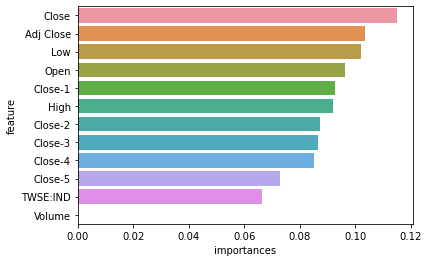

In [2]:
n = day_n/training_set.shape[0]
(X_trainRF, X_testRF, Y_trainRF, Y_testRF) = train_test_split(data_set , label_set, test_size=n,shuffle=False )

training_set.head()

from sklearn.ensemble import ExtraTreesRegressor
import seaborn as sns
forest = ExtraTreesRegressor(n_estimators=2500, random_state=0)
forest.fit(X_trainRF, Y_trainRF) 

importances = forest.feature_importances_ 
select = pd.DataFrame(importances)
select.columns = ["importances"] 
select['feature']=list(X_trainRF.columns)
select = select.sort_values(by=['importances'], ascending=False)
sns.barplot(y= 'feature',x = 'importances',data=select)

select = select.drop(select[select['importances']>importance_n].index)
training_set = training_set.drop(training_set[select['feature']], axis=1)

data_set = training_set.drop(['Date','Label'], axis=1)
label_set= training_set.drop(training_set.columns.difference(['Label']), axis=1)
(X_train, X_test, Y_train, Y_test) = train_test_split(data_set , label_set, test_size=n,shuffle=False )

In [3]:
X_df = pd.DataFrame([], columns=['Y_RFR_pred', 'Y_svm_pred', 'Y_KNN_pred', 'Y_BR_pred'])
Y_df = pd.DataFrame([], columns=['Label'])

set_m1 = set_train_model()

blank = int(len(Y_train)/10)
for i in range(blank,len(Y_train)-blank,blank):
    set_m1 = set_train_fit(X_train[0:i], Y_train[0:i], set_m1)
    out1   = train_predict(X_train[i:i+blank], Y_train[i:i+blank], set_m1)
    X_df=pd.concat([X_df,out1])
    Y_df=pd.concat([Y_df,Y_train[i:i+blank]])
X_df.index = range(len(X_df))
Y_df.index = range(len(Y_df))

In [4]:
set_m2 = set_train_model()
set_m2 =set_train_fit(X_df, Y_df, set_m2)

model_one_out = train_predict(X_test, Y_test, set_m1)
model_Two_out = train_predict(model_one_out, Y_test, set_m2)

single_test_result
	RandomForestRegressor:
 		RMSE:0.018450928717776566
		MAPE:2.3262167681316566
	svm.SVR:
 		RMSE:0.01589839629060992
		MAPE:1.6504588182481559
	KNN:
 		RMSE:0.017752927973807568
		MAPE:1.670934174609694
	BayesianRidge:
 		RMSE:0.015888374146829868
		MAPE:1.6595986520726729

single_test_result
hybrid_test_result
	RandomForestRegressor:
 		RMSE:0.017094332838632414
		MAPE:1.8484323805639136
	svm.SVR:
 		RMSE:0.015530271349783301
		MAPE:1.6086810994435292
	KNN:
 		RMSE:0.021592908154351914
		MAPE:2.4817318342394596
	BayesianRidge:
 		RMSE:0.015917617108737448
		MAPE:1.65955171510137

hybrid_test_result


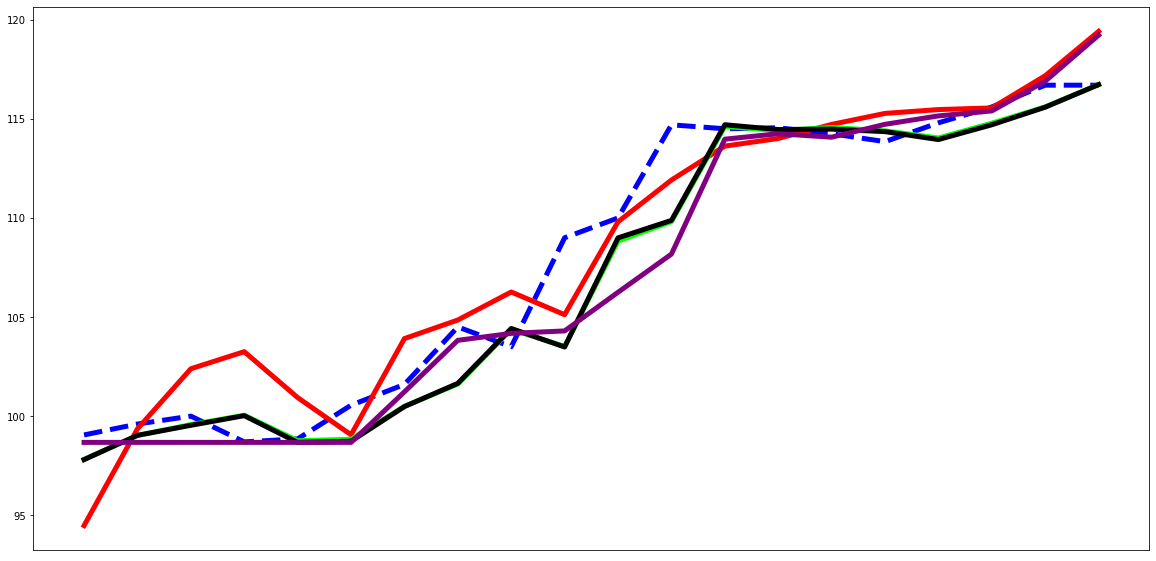

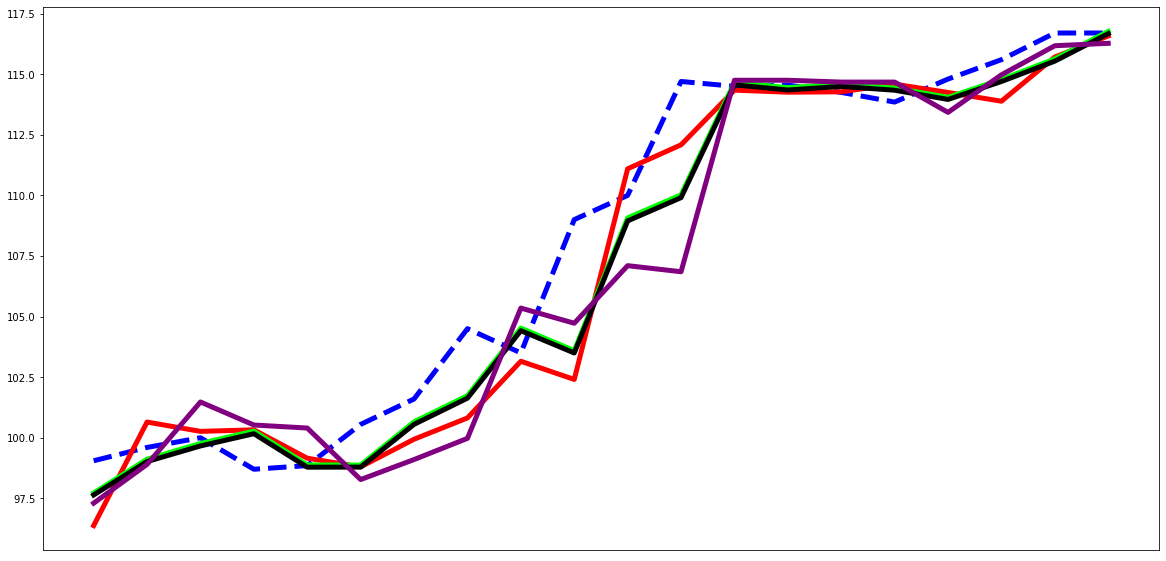

In [5]:
file_name=file_name+'_imp='+str(importance_n)
e1_name = file_name+': single_test_result'
print('single_test_result')
print_evaluation(X_test, Y_test, model_one_out,e1_name) 
show_plot_dataframe(e1_name, model_one_out, Y_test,'single_test_result',label_nal,training_set) 

print('hybrid_test_result')
e2_name = file_name+': hybrid_test_result'
print_evaluation(X_test, Y_test, model_Two_out,e2_name) 
show_plot_dataframe(e2_name, model_Two_out, Y_test,'hybrid_test_result',label_nal,training_set)

In [6]:
from sklearn.cluster import KMeans
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib import rc
import itertools
from sklearn.preprocessing import StandardScaler
#Euclidean distance
def dist(a, b):
    return np.linalg.norm(a - b, None)
#Tau-distance
def tau_dist_fun(x, centroid, tau):
    arr = x - centroid
    tau_ar = tau[None:,:]
    neg = np.array([arr<0],dtype=np.int32)
    pos = np.array([arr>=0],dtype=np.int32)
    w_pos = pos * tau_ar
    w_neg = neg * (1-tau_ar)
    dist = (arr ** 2 * w_pos).sum(axis = arr.ndim) + (arr ** 2 * w_neg).sum(axis = arr.ndim)
    return dist
#get centroids
def get_closest_centroid(x, centroid, tau):
    # Loop over each centroid and compute the distance from data point.
    dist = tau_dist_fun(x, centroid, tau)
    # Get the index of the centroid with the smallest distance to the data point
    assigned_centroids = np.argmin(dist, axis = 2)
    clusters = np.squeeze(assigned_centroids)
    return clusters
#Expectile estimation
def expectile_fun_c(group, tau):
    e = np.mean(group, axis=0)
    e_new = np.zeros(e.shape)
    while dist(e_new , e) != 0:
        res = group - e
        e = copy.deepcopy(e_new)
        neg = np.array([res<0],dtype = np.int32)
        pos = np.array([res>=0],dtype= np.int32)
        norm = pos.sum(axis=1)*tau + neg.sum(axis=1)*(1-tau)
        e_arr = (tau * (group * pos).sum(axis=1) + (1-tau) * (group * neg).sum(axis=1))/norm
        e_new = np.squeeze(e_arr)
    return e_new
#Estimate optimal taus
def tau_fun_c(group, e):
    res = group - e
    neg = np.array([res<0],dtype = np.int32)
    pos = np.array([res>=0],dtype= np.int32)
    neg_s = -(neg*res).sum(axis=1)/neg.sum(axis=1)
    pos_s = (pos*res).sum(axis=1)/pos.sum(axis=1)
    c = neg_s/pos_s
    tau = c/(1+c)
    return tau
# Define K expectile clustering 
# Main function
def k_expectile_vtau_c(X, k):
    X = np.array(X)
# Initialize cluster centers as K means cluster centers
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    C = kmeans.cluster_centers_

# To store the value of centroids when it updates
    C_old = np.zeros(C.shape)
# Initialize tau = 0.5
    tau = np.ones(C.shape)*0.5
# Error func. - Distance between new centroids and old centroids
    error = dist(C, C_old)
# main loop    
    for r in range(30):
        # Get closest centroids to each data point
        assigned_clusters = get_closest_centroid(X[:, None, :], C[None,:, :], tau)
        # Storing the old centroid values
        C_old = copy.deepcopy(C)
        # Compute new centroids
        for c in range(k):
            # Get data points belonging to each cluster 
            cluster_members = X[assigned_clusters == c]
        
            # Compute the centroids of the clusters
            C[c] = expectile_fun_c(cluster_members, tau[c])
        
            tau[c] = tau_fun_c(cluster_members, C[c])
        error = dist(C, C_old)
    return C, assigned_clusters, tau


def cluster_index(clusters, target, k):
    list_p = list(range(0,k,1))
    permu = list(itertools.permutations(list_p,k))
    new = np.zeros(clusters.shape)
    acc = np.zeros(len(permu))
    for i in range(len(permu)):
        for j in range(0,k,1):
            new[np.where(clusters == j)] = permu[i][j]
        acc[i] = np.sum(new == target)/len(target)
    index = permu[np.argmax(acc)]
    return index, np.max(acc)
training_set = newtraining_set  
new_data_set = training_set.reindex(columns=['Date','TWSE:IND','Close'])
new_set_without_date = training_set.reindex(columns=['TWSE:IND','Close'])


Std_cvc = StandardScaler().fit_transform(new_set_without_date)
Std_cvc = np.array(Std_cvc)

k = 3
C_e, clusters_e, tau_e= k_expectile_vtau_c(Std_cvc,k)
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=k)
spectral.fit(Std_cvc)
clusters_s = spectral.labels_

kmeans = KMeans(n_clusters=k)
kmeans.fit(Std_cvc)
clusters_m = kmeans.labels_
C_m = kmeans.cluster_centers_


index1,acc1 = cluster_index(clusters_e,clusters_m,k)
new1 = np.zeros(len(clusters_e))
for j in range(k):
    new1[np.where(clusters_e == j)] = index1[j]
index2,acc2 = cluster_index(clusters_s,clusters_m,k)
new2 = np.zeros(len(clusters_s))
for j in range(k):
    new2[np.where(clusters_s == j)] = index2[j]

# read data
df = new_data_set
df.index = pd.to_datetime(df['Date'], yearfirst=True)

year = mdates.YearLocator()
month = mdates.MonthLocator()


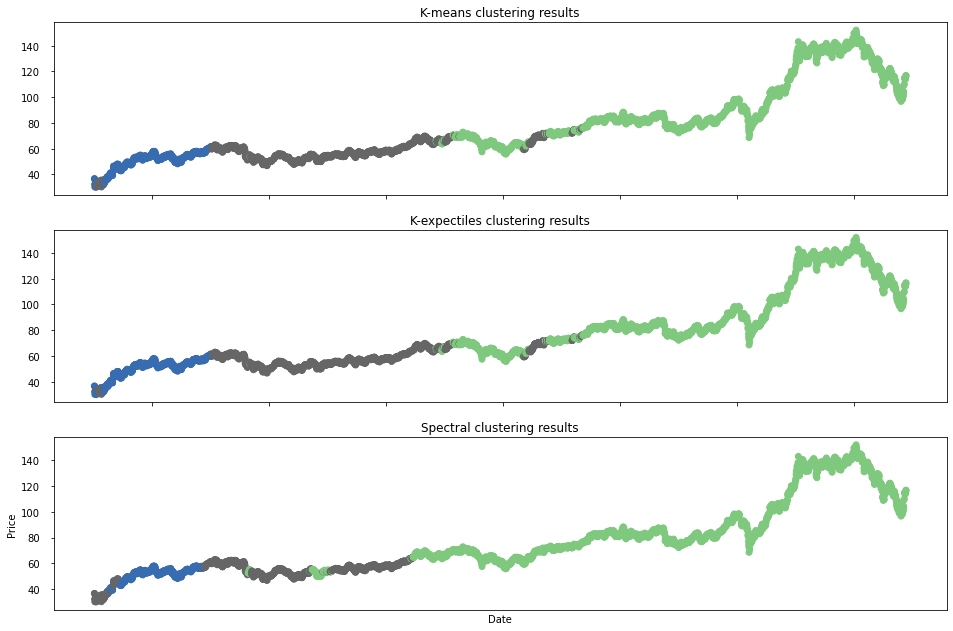

In [7]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df['Close'].values, c=clusters_m[::-1], cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
axes[0].tick_params(pad=10)

axes[1].scatter(df.index, df['Close'].values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
axes[1].tick_params(pad=10)

axes[2].scatter(df.index, df['Close'].values, c=new2[::-1], cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Price')
axes[2].tick_params(pad=10)
plt.savefig('Clustering_results_a.png',transparent=True)

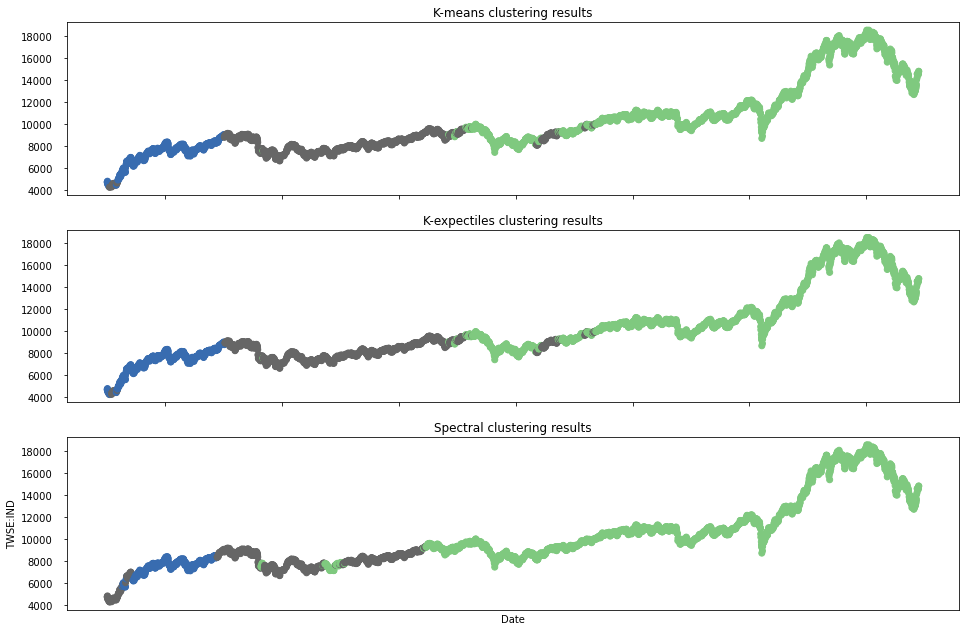

In [8]:
plt.rcParams['figure.figsize'] = (16, 12)
fig, ax = plt.subplots(3,1)
axes = ax.flatten()
axes[0].scatter(df.index, df['TWSE:IND'].values, c=clusters_m[::-1], cmap=plt.get_cmap('Accent'))
axes[0].set_title('K-means clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('TWSE:IND')
axes[0].tick_params(pad=10)

axes[1].scatter(df.index, df['TWSE:IND'].values, c=new1[::-1], cmap=plt.get_cmap('Accent'))
axes[1].set_title('K-expectiles clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('TWSE:IND')
axes[1].tick_params(pad=10)

axes[2].scatter(df.index, df['TWSE:IND'].values, c=new2[::-1], cmap=plt.get_cmap('Accent'))
axes[2].set_title('Spectral clustering results')
plt.xticks([])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('TWSE:IND')
axes[2].tick_params(pad=10)
plt.savefig('Clustering_results_b.png',transparent=True)

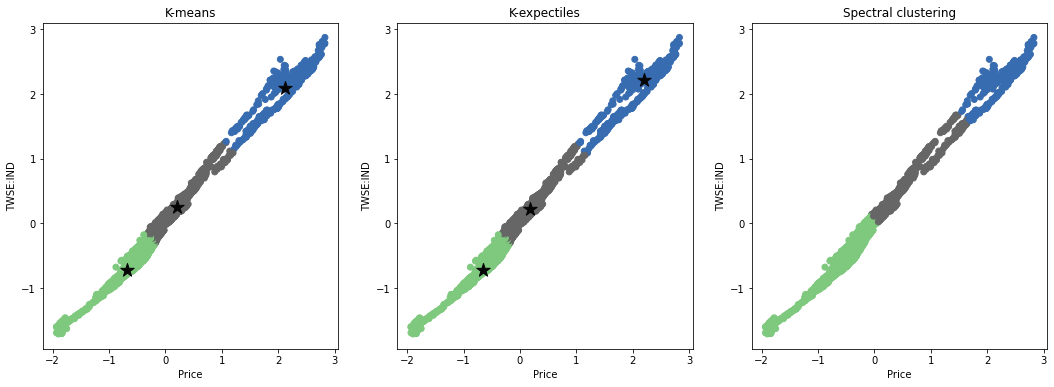

In [9]:
plt.rcParams['figure.figsize'] = (18,6)
plt.subplot(131)
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= clusters_m, cmap=plt.get_cmap('Accent'))
plt.scatter(C_m[:,0], C_m[:,1],marker='*', s=200, c='#050505')
plt.xlabel('Price')
plt.ylabel('TWSE:IND')
plt.title('K-means')

plt.subplot(132)
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new1, cmap=plt.get_cmap('Accent'))
plt.scatter(C_e[:,0], C_e[:,1],marker='*', s=200, c='#050505')
plt.xlabel('Price')
plt.ylabel('TWSE:IND')
plt.title('K-expectiles')

plt.subplot(133) 
plt.scatter( Std_cvc[:,0], Std_cvc[:,1],c= new2, cmap=plt.get_cmap('Accent'))
plt.xlabel('Price')
plt.ylabel('TWSE:IND')
plt.title('Spectral clustering')
plt.savefig('data_view.png',transparent=True)